In [1]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

from tensorflow.python.keras.applications.efficientnet import EfficientNetB7 as tfk_BaseModel
from tensorflow.python.keras.applications.efficientnet import preprocess_input as tfk_preprocess_input

# pip install git+https://github.com/docPhil99/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
import albumentations as A

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from PIL import Image, ImageEnhance

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

## Prepare Dataset

### Load and combine datasets

In [24]:
pd_shopee_train = pd.read_csv('shopee-product-detection-dataset/train.csv')
pd_confusing_images = pd.read_csv('shopee-product-detection-dataset/confusing_images_2__mistake_ratio=0.9.csv')
pd_amazon_train = pd.read_csv('amazon-scraped-dataset/amazon.csv')

In [25]:
# uncomment to clean up the shopee dataset
# mask = ~pd_shopee_train.set_index('dir_filename').index.isin(pd_confusing_images.set_index('dir_filename').index)
# pd_shopee_train = pd_shopee_train.loc[mask].copy()

In [26]:
pd_shopee_train['category']     = pd_shopee_train['category'].apply(lambda x : '{:02d}'.format(x))
pd_shopee_train['dir_filename'] = pd_shopee_train.apply(lambda x: 'shopee-product-detection-dataset/train/{}/{}'.format(x.category, x.filename), axis=1)

pd_amazon_train['category']     = pd_amazon_train['category'].apply(lambda x : '{:02d}'.format(x))
pd_amazon_train['dir_filename'] = pd_amazon_train.apply(lambda x: 'amazon-scraped-dataset/{}/{}'.format(x.category, x.filename), axis=1)

In [27]:
pd_combined_dataset = pd_shopee_train.merge(pd_amazon_train, how='outer')
# random shuffle
pd_combined_dataset = pd_combined_dataset.sample(frac=1).reset_index(drop=True)
pd_combined_dataset.head()

,filename,category,dir_filename
0,41fKFbPPHaL.jpg,16,amazon-scraped-dataset/16/41fKFbPPHaL.jpg
1,625558e66760fbb8eca23240cb7f84e0.jpg,19,shopee-product-detection-dataset/train/19/6255...
2,31N7VH6BhyL.jpg,21,amazon-scraped-dataset/21/31N7VH6BhyL.jpg
3,624a4fc09fa612912b1c07d6b7847712.jpg,40,shopee-product-detection-dataset/train/40/624a...
4,41l_2BewK5OvL.jpg,20,amazon-scraped-dataset/20/41l_2BewK5OvL.jpg


In [28]:
assert(len(pd_shopee_train) + len(pd_amazon_train) == len(pd_combined_dataset))
assert(np.all(np.unique(pd_combined_dataset['category']) == 
              np.array(['{:02d}'.format(cat) for cat in range(42)])))

### Prepare data generators

In [29]:
input_shape = (256, 256, 3)
batch_size  = 64

In [30]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
    ], p = 0.3),
    A.OneOf([
        A.ElasticTransform(
            alpha = 120,
            sigma = 120 * 0.05,
            alpha_affine = 120 * 0.03
        ),
        A.GridDistortion(),
        A.OpticalDistortion(
            distort_limit = 2,
            shift_limit = 0.5
        ),
    ], p = 0.3),
    A.OneOf([
        A.Cutout(
            num_holes=4,
            max_h_size=64,
            max_w_size=64
        ),
        A.GridDropout(
            ratio=0.25,
            holes_number_x=8,
            holes_number_y=8
        ),
    ], p=1),
])

In [31]:
train_datagen = ImageDataAugmentor(
    preprocess_input=tfk_preprocess_input,
    validation_split=0.1,
    augment=AUGMENTATIONS,
)

train_generator = train_datagen.flow_from_dataframe(
    pd_combined_dataset,
    directory='',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    pd_combined_dataset,
    directory='',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 137684 validated image filenames belonging to 42 classes.
Found 15298 validated image filenames belonging to 42 classes.


### Check class distributions

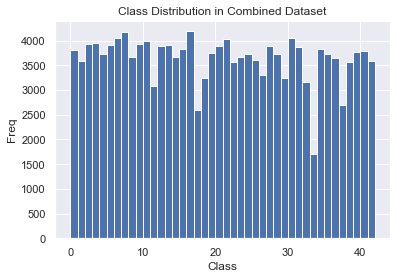

In [33]:
plt.title("Class Distribution in Combined Dataset")
plt.xlabel("Class")
plt.ylabel("Freq")
plt.hist(pd_combined_dataset['category'].astype(int), bins=np.arange(43));

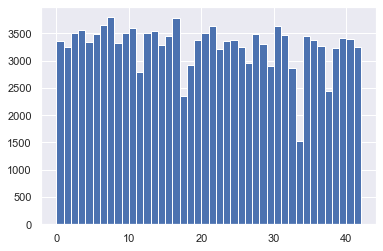

In [34]:
plt.hist(train_generator.classes, bins=np.arange(43));

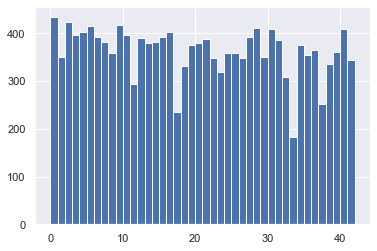

In [35]:
plt.hist(val_generator.classes, bins=np.arange(43));

### Calculate class weights

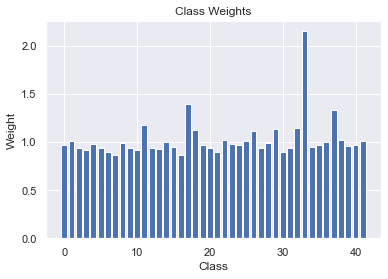

In [36]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
plt.title("Class Weights")
plt.ylabel("Weight")
plt.xlabel("Class")
plt.bar(class_weights.keys(), class_weights.values());

## Prepare Model

In [ ]:
base_model = tfk_BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)

In [ ]:
TYPE = 3
if TYPE == 1:
    for layer in base_model.layers[:-18]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dense(512, activation='relu'),
        tfk.layers.Dense(128, activation='relu'),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
elif TYPE == 2:
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
    base_model.trainable = False
elif TYPE == 3:
    for layer in base_model.layers[:-len(base_model.layers)//5]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Model)       (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d (Global (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 42)                107562    
Total params: 64,205,249
Trainable params: 38,267,402
Non-trainable params: 25,937,847
_________________________________________________________________


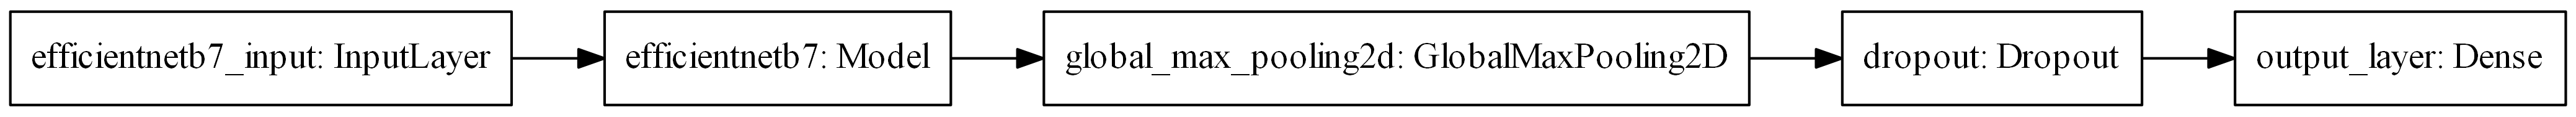

In [10]:
tfk.utils.plot_model(model, rankdir='LR', dpi=300, show_shapes=False)

In [ ]:
# model.save('model_aug_full_4.h5')

## Train Top Layers of Model

### Load model

In [14]:
model = tfk.models.load_model('model_aug_full_4.h5')

### Prepare callbacks

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=10,
    min_lr=1e-6
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

log_dir = os.path.join(".model_files/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = log_dir + '/ckpt/',
    save_freq ='epoch',
    save_best_only=True,
    monitor='val_loss'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    update_freq=100,
    write_graph=False,
    profile_batch = 0
)

class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir, **kwargs):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr_sched = getattr(self.model.optimizer, "lr", None)
        logs.update({'lr': tf.keras.backend.get_value(lr_sched(tf.cast(self.model.optimizer.iterations, tf.float32)))})
        super().on_epoch_end(epoch, logs)

lr_tensorboard_callback = LRTensorBoard(log_dir=log_dir)
        
#tqdm_callback = tfa.callbacks.TQDMCallback()

### Compile model

In [16]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=1e-3,
    step_size=2*train_generator.n//batch_size
)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

### Train model

In [17]:
history = model.fit(train_generator,
                    initial_epoch=124,
                    epochs=500,
                    steps_per_epoch=200,
                    validation_steps=20,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=[reduce_lr,
                               early_stop, 
                               #checkpoint, 
                               tensorboard_callback,
                               #lr_tensorboard_callback,
                               #tqdm_callback
                              ]
                   )

Epoch 125/500
200/200 [==============================] - 243s 1s/step - loss: 1.6595 - accuracy: 0.6769 - val_loss: 1.4969 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 126/500
200/200 [==============================] - 244s 1s/step - loss: 1.6426 - accuracy: 0.6798 - val_loss: 1.5268 - val_accuracy: 0.7148 - lr: 1.0000e-04
Epoch 127/500
200/200 [==============================] - 242s 1s/step - loss: 1.5963 - accuracy: 0.6938 - val_loss: 1.5061 - val_accuracy: 0.7266 - lr: 1.0000e-04
Epoch 128/500
200/200 [==============================] - 243s 1s/step - loss: 1.5683 - accuracy: 0.7025 - val_loss: 1.4622 - val_accuracy: 0.7367 - lr: 1.0000e-04
Epoch 129/500
200/200 [==============================] - 242s 1s/step - loss: 1.5834 - accuracy: 0.6975 - val_loss: 1.4372 - val_accuracy: 0.7516 - lr: 1.0000e-04
Epoch 130/500
200/200 [==============================] - 242s 1s/step - loss: 1.5752 - accuracy: 0.6967 - val_loss: 1.4604 - val_accuracy: 0.7453 - lr: 1.0000e-04
Epoch 131/500
200/200 

### Save model

In [18]:
model.save('model_aug_full_5.h5')

## Testing

We'll do in-sample testing here. A bit non-standard, but good enough.

In [19]:
# model = tfk.models.load_model('model_clean_3.h5')

### Prepare unaugmented dataset generator

In [47]:
clean_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
)

clean_generator = clean_datagen.flow_from_dataframe(
    pd_shopee_train,
    directory='',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 105392 validated image filenames belonging to 42 classes.


### Predict

In [48]:
%%time
y_pred = []
y_true = []

for i in range(50):
    if (i+1) % 10 == 0:
        print("step:", i+1)
    x, y = next(iter(clean_generator))
    y_true.extend(y)
    y_pred.extend(model.predict(x))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

step: 10
step: 20
step: 30
step: 40
step: 50
Wall time: 53.7 s


In [49]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

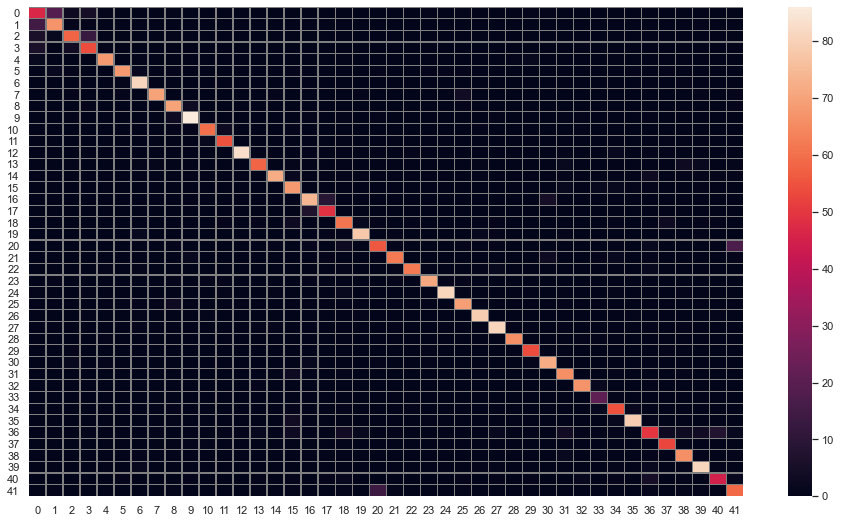

In [50]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix, linecolor='grey', linewidth=0.1)
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [51]:
def label_smoother(x, alpha=0.1):
    return (1 - alpha) * x + alpha / x.shape[1]

In [52]:
loss     = tfk.losses.categorical_crossentropy(y_pred, label_smoother(y_true, alpha=0.1)).numpy().mean()
accuracy = accuracy_score(y_pred.argmax(axis=1), y_true.argmax(axis=1))

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 1.7400043
Accuracy: 0.850625


## Generate Submission

### Prepare test data generator

In [33]:
pd_test = pd.read_csv('shopee-product-detection-dataset/test.csv')
pd_test.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [34]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 12186 validated image filenames.


### Predict categories

In [35]:
y_pred = model.predict(test_generator, verbose=1, steps=test_generator.n//batch_size+1)
y_pred = y_pred[:test_generator.n]

191/191 [==============================] - 148s 774ms/step


In [36]:
pd_submission = pd_test.copy()
pd_submission['category'] = list(map(lambda x : '{:02d}'.format(x), y_pred.argmax(axis=1)))
pd_submission.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,41
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [37]:
pd_submission.to_csv('submission_11.csv', index=False)

### Compare to previous submission

In [44]:
now  = 11
cat_now_name  = 'category_{}'.format(now)
prev = 10
cat_prev_name = 'category_{}'.format(prev)

pd_submission_prev = pd.read_csv('submission_{}.csv'.format(prev))
pd_submission_prev['category'] = pd_submission_prev['category'].apply(lambda x : '{:02d}'.format(x))
pd_submission_prev.columns = ['filename', cat_prev_name]
pd_submission_prev = pd_submission_prev.merge(pd_submission.sort_values(by='filename'), on='filename')
pd_iba = pd_submission_prev[pd_submission_prev[cat_prev_name] != pd_submission_prev['category']]
print(len(pd_iba), len(pd_submission_prev), len(pd_iba) / len(pd_submission_prev))
pd_iba.head(20)

719 12186 0.059002133595929755


,filename,category_10,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20,41
20,8149a8a19f2fed05ce3ac20e5b7cbab0.jpg,06,05
57,7fbe6dd0725f45bb33ff69c2e2a5b3f9.jpg,40,02
92,0f76078f68b2d6ae47e86ae488b6de08.jpg,00,02
129,c6da8a0a2109e30d994ca430ffb7209b.jpg,38,36
133,d6a75e743ce70a2aff29a54beabf78f6.jpg,34,33
139,8c6df772f1a99cc75b7de3f2398fe605.jpg,25,07
153,0d0811d343d8c02eceb1a38822f04a35.jpg,12,05
190,c748620e9c40ad8cfd4142efa7735290.jpg,22,11
227,de11b62c808ef927967b495bd5f2d7a9.jpg,00,01


In [45]:
pd_iba.to_csv("iba.csv", index=False)

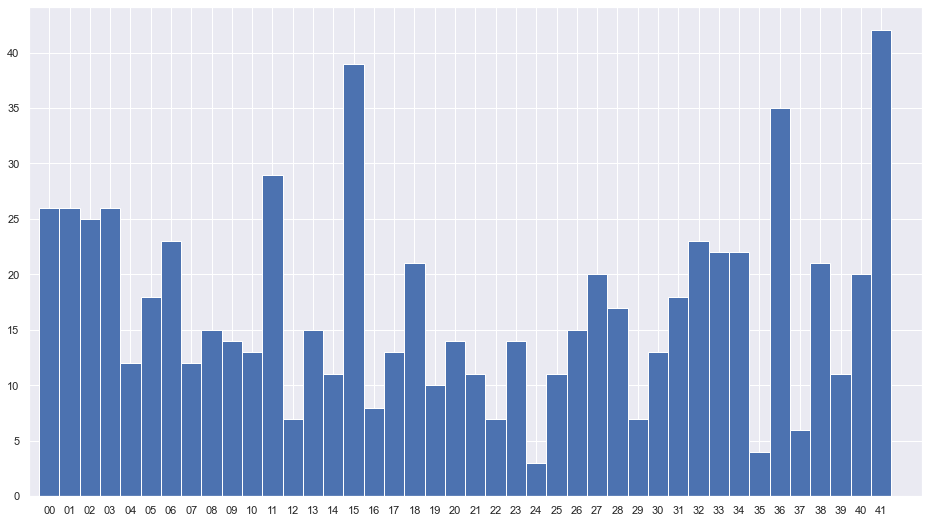

In [46]:
plt.figure(figsize=(16, 9))
plt.hist(pd_iba['category'].sort_values(), bins=np.arange(43)-0.5)
plt.xlim(-1, 43)
plt.show()